In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix



# 数据预处理和加载

In [3]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:06<00:00, 26.9MB/s]


# 定义CNN模型

In [4]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 训练过程

In [6]:
num_epochs = 20
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 测试集评估
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    test_acc = test_correct / test_total
    test_accs.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch [1/20], Loss: 1.6080, Train Acc: 0.4069, Test Acc: 0.5384
Epoch [2/20], Loss: 1.2570, Train Acc: 0.5450, Test Acc: 0.6336
Epoch [3/20], Loss: 1.0912, Train Acc: 0.6110, Test Acc: 0.6881
Epoch [4/20], Loss: 0.9814, Train Acc: 0.6509, Test Acc: 0.7123
Epoch [5/20], Loss: 0.9123, Train Acc: 0.6772, Test Acc: 0.7292
Epoch [6/20], Loss: 0.8588, Train Acc: 0.6953, Test Acc: 0.7483
Epoch [7/20], Loss: 0.8223, Train Acc: 0.7103, Test Acc: 0.7628
Epoch [8/20], Loss: 0.7833, Train Acc: 0.7241, Test Acc: 0.7726
Epoch [9/20], Loss: 0.7524, Train Acc: 0.7365, Test Acc: 0.7799
Epoch [10/20], Loss: 0.7338, Train Acc: 0.7414, Test Acc: 0.7831
Epoch [11/20], Loss: 0.7162, Train Acc: 0.7460, Test Acc: 0.7795
Epoch [12/20], Loss: 0.7002, Train Acc: 0.7535, Test Acc: 0.7823
Epoch [13/20], Loss: 0.6813, Train Acc: 0.7613, Test Acc: 0.7940
Epoch [14/20], Loss: 0.6640, Train Acc: 0.7676, Test Acc: 0.8047
Epoch [15/20], Loss: 0.6473, Train Acc: 0.7736, Test Acc: 0.8038
Epoch [16/20], Loss: 0.6432, Train

# 绘制训练曲线

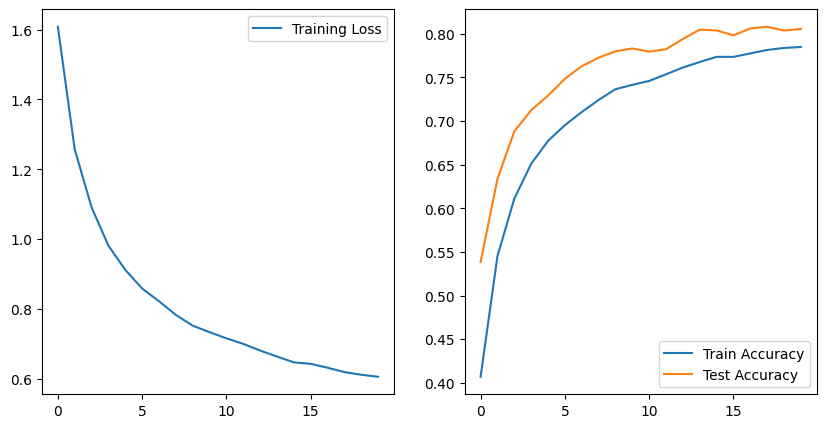

In [7]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.show()

# 计算每个类别的Precision

In [8]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
precision_per_class = cm.diagonal() / cm.sum(axis=0)
precision_per_class = np.nan_to_num(precision_per_class, nan=0.0)

for i, prec in enumerate(precision_per_class):
    print(f'Class {i} Precision: {prec:.4f}')

print(f'Overall Accuracy: {test_accs[-1]:.4f}')

Class 0 Precision: 0.7715
Class 1 Precision: 0.9376
Class 2 Precision: 0.7245
Class 3 Precision: 0.7386
Class 4 Precision: 0.7457
Class 5 Precision: 0.7040
Class 6 Precision: 0.8542
Class 7 Precision: 0.7866
Class 8 Precision: 0.9162
Class 9 Precision: 0.8900
Overall Accuracy: 0.8055
